# OpenFOAM HRM Log Analysis

This program plots data from HRMFoam log files for analysis (i.e. net mass flux).
The data should already be extracted to HDF using ReadHRMLog.

In the convergence script, we assumed that they were parts of the timeseries for the same run.
In this script, we assume the various datasets in each group are for seperate repeats/runs.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 16/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
# Load modules
import numpy as np
import natsort, os
import h5py
import matplotlib.pyplot as plt
%matplotlib notebook

In [98]:
topLevel = "/mnt/internal-hdd/2021_pmdi/newGeomTrial/postProcessing/massFlux/newGeomTrial/"

'''
['Mass flux at inlet', 'Mass flux at outlet_axial', 'Mass flux at outlet_radial', 'Mass flux at walls',
'Maximum density', 'Maximum pressure', 'Maximum velocity', 'Minimum density', 'Minimum pressure',
'Momentum flux at inlet', 'Momentum flux at outlet_axial', 'Momentum flux at outlet_radial',
'Momentum flux at walls', 'Net mass flux', 'time']
'''
varPlotted = 'Mass flux at inlet'
scalingFun = lambda x: -x/0.144625 # kg/s to g/s or mg/ms
unit = 'Mass flux ratio to exp. [-]' #'Mass flux [g/s]'


kernel = np.hamming(512)
BINNING = 512

In [99]:
def read_file(filename):
    t_all=[]
    y_all=[]
    s=[]
    with h5py.File(filename,'r') as H:
        for k in H.keys():
            if isinstance(H[k],h5py.Group):
                if varPlotted in H[k]:
                    t = H[k]['time'][...]
                    y = H[k][varPlotted][...]

                    # Truncate time to match y
                    t = t[:len(y)]

                    # Sort by time
                    idx = np.argsort(t)
                    y = y[idx]
                    t = t[idx]

                    # Mask zeros
                    mask = (y==0)&(t==0)
                    t[mask]=np.nan
                    y[mask]=np.nan

                    # Smooth data 
                    ys = np.convolve(y, kernel,'same')

                    # Export smoothed , binned data
                    # Remove the first and last few iterations.
                    y_all.append(ys[100:-1000:BINNING])
                    t_all.append( t[100:-1000:BINNING])

                    s.append(  k.replace('.txt.gz','').replace('_',' ') )
                
    return t_all,y_all,s

## Read and plot the mass flux 

Reading newGeomTrial_134a...


<IPython.core.display.Javascript object>


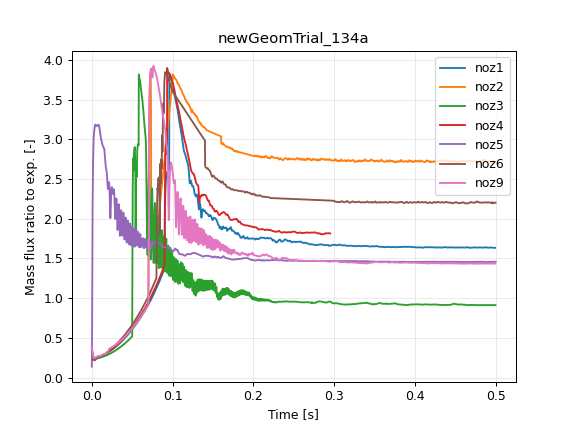

Reading newGeomTrial_152a...


<IPython.core.display.Javascript object>


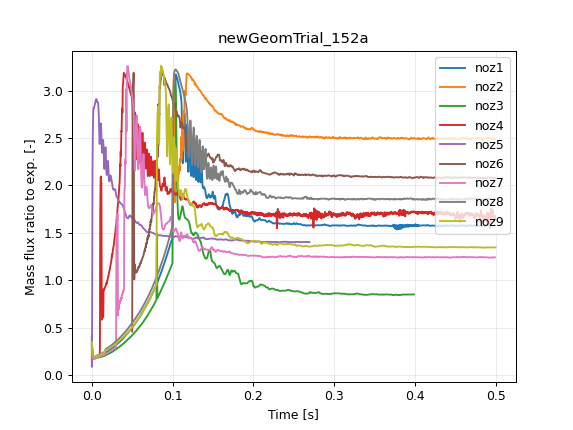

Reading newGeomTrial_1234ze...


<IPython.core.display.Javascript object>


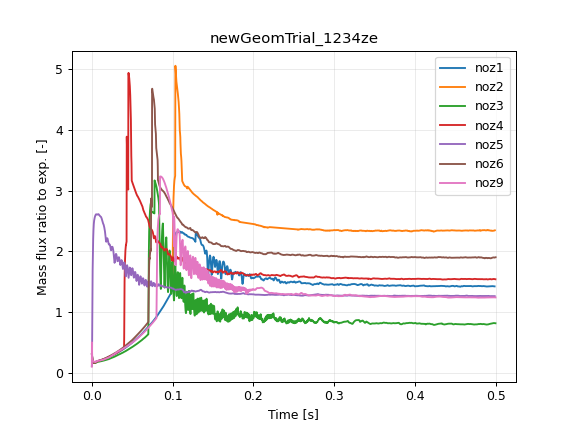

Reading newGeomTrial_134a15pcEtOH...


<IPython.core.display.Javascript object>


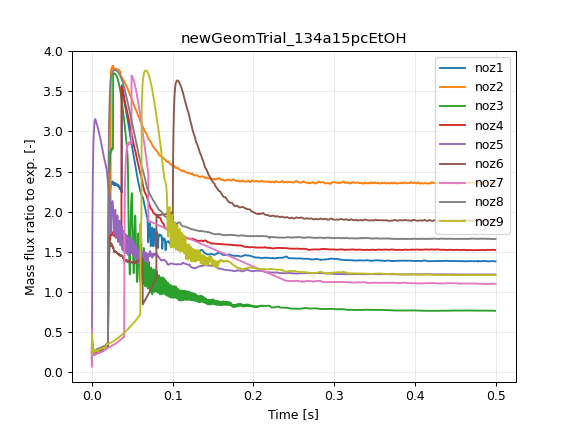

Reading newGeomTrial_152a15pcEtOH...


<IPython.core.display.Javascript object>


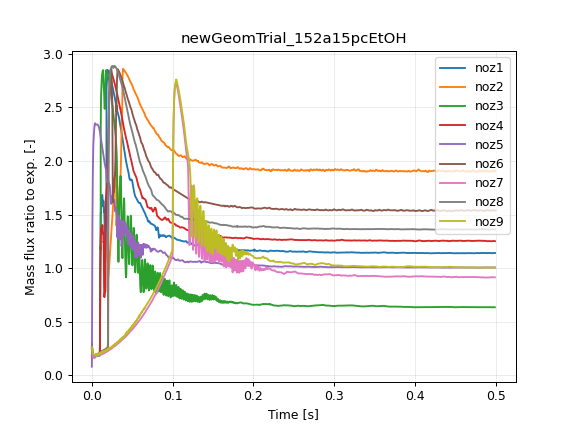

Reading newGeomTrial_1234ze15pcEtOH...


<IPython.core.display.Javascript object>


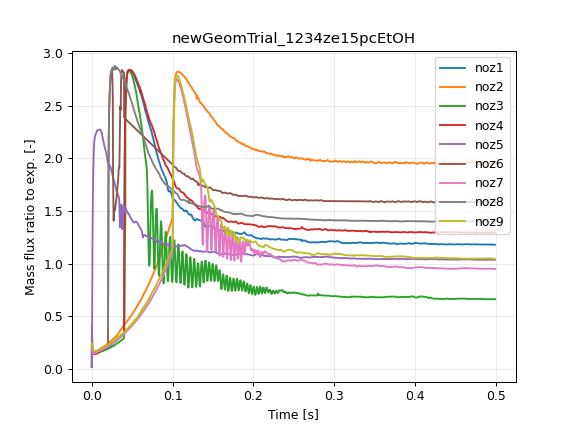

In [212]:
data = {}

for f in ['newGeomTrial_134a', 'newGeomTrial_152a', 'newGeomTrial_1234ze',\
          'newGeomTrial_134a15pcEtOH', 'newGeomTrial_152a15pcEtOH', 'newGeomTrial_1234ze15pcEtOH']:
    
    print("Reading %s..." % f)
    
    t,y,s = read_file(topLevel+f+'.h5')
    data[f] = t,y,s
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.grid(alpha=.25)
    for i in range(len(s)):
        ax.plot(t[i],scalingFun(y[i]),label=s[i].split(' ')[0])
    plt.legend(loc=1)
    plt.title(f)
    plt.ylabel(unit); plt.xlabel('Time [s]')
    

## Plot the data by nozzle type rather than propellant

<IPython.core.display.Javascript object>


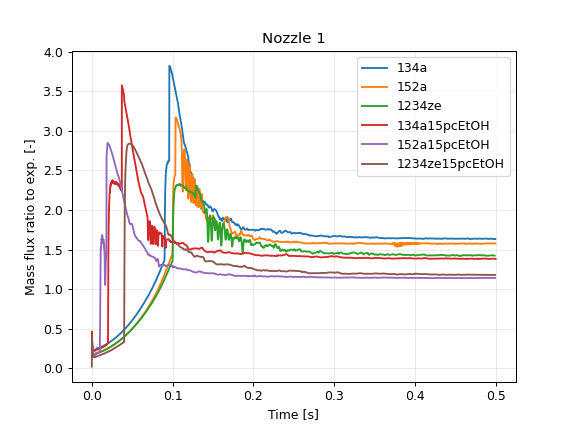

<IPython.core.display.Javascript object>


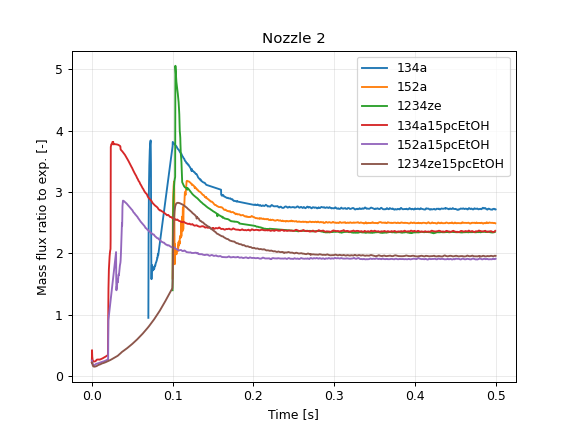

<IPython.core.display.Javascript object>


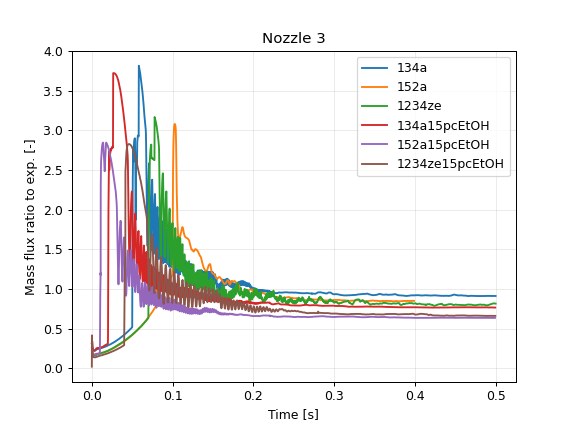

<IPython.core.display.Javascript object>


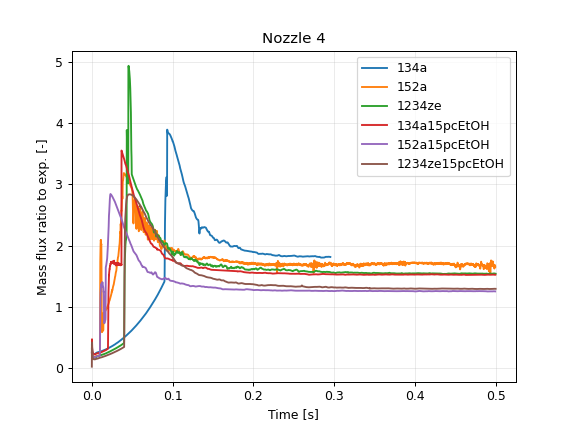

<IPython.core.display.Javascript object>


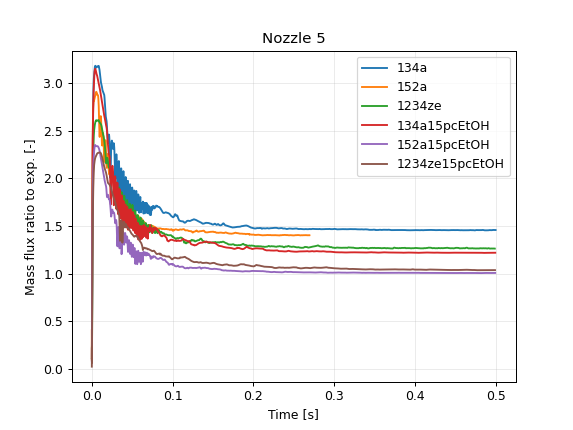

<IPython.core.display.Javascript object>


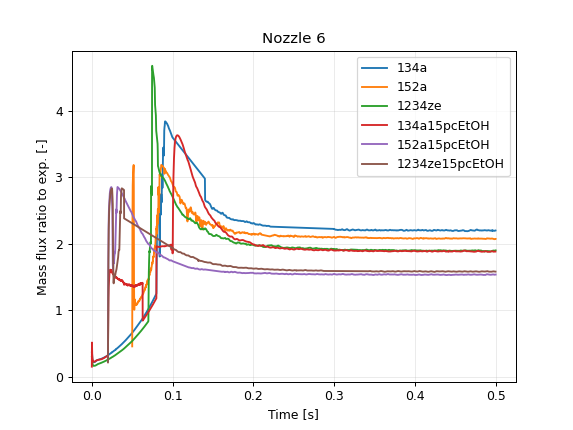

<IPython.core.display.Javascript object>


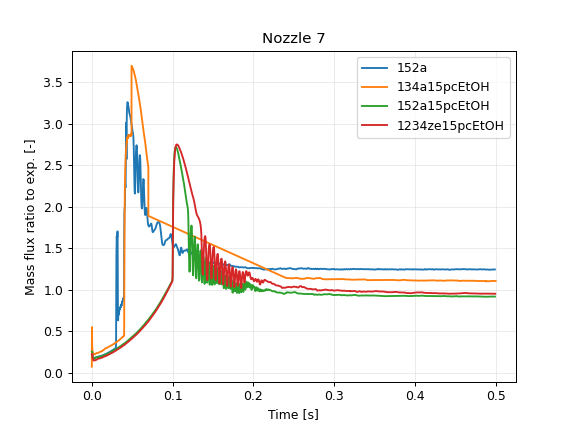

<IPython.core.display.Javascript object>


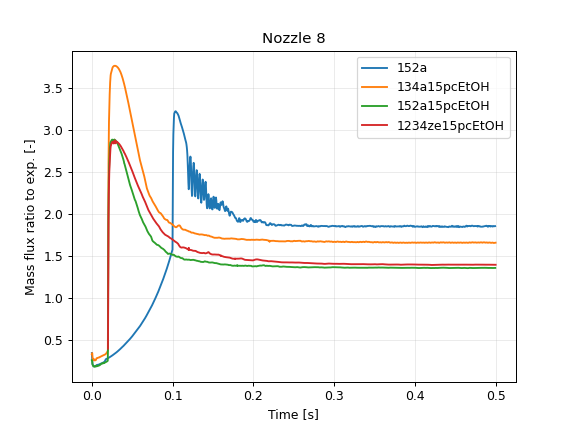

<IPython.core.display.Javascript object>


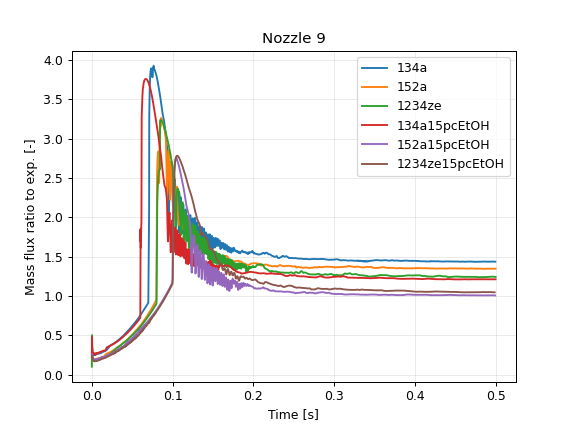

In [213]:
nn = np.arange(1,10)
for n in nn:
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.grid(alpha=.25)
    plt.title("Nozzle %i" % n)
    nt = 'noz%i' % n
    for d in data.keys():
        s = data[d][2]
        for i in range(len(s)):
            if (nt in s[i]):
                t = data[d][0][i]
                y = data[d][1][i]
                ax.plot(t,scalingFun(y),label=s[i].replace(nt+' ',''))
        
    plt.legend()
    plt.ylabel(unit); plt.xlabel('Time [s]');

## Generate table of steady state mass fluxes

In [214]:
print('\t'*2,'\t'.join(['Noz.%i' % n for n in nn]))
print('-'*100)

all_means=np.ndarray((0,len(nn)))
all_stds =np.ndarray((0,len(nn)))
all_props = []

j=0
for k in data.keys():
    d = data[k]
    means = [np.nan]*len(nn)
    stds= [np.nan]*len(nn)
    for n in range(len(d[0])):
        y = scalingFun(d[1][n])
        t = d[0][n]
        p = d[2][n].split(' ')[1]
        noznum = int(d[2][n].split(' ')[0][-1])
        tmax = np.nanmax(t)
        yss = y[t>tmax-0.1]
        means[noznum-1] = np.nanmean(yss)
        stds[noznum-1] = np.nanstd(yss)
    
    kstr=p.replace('15pcEtOH',' 15%')
    while(len(kstr)<10):kstr+=' '
    print(kstr,'\t',\
          '\t'.join(['%0.4f' % (means[i]) for i in range(len(means))]))
    print('\t\t',\
          '\t'.join(['\u00b1%.3f' % (stds[i]) for i in range(len(means))]))
    print('-'*100)
    
    all_means = np.vstack((all_means,means))
    all_stds  = np.vstack((all_stds,stds))
    all_props.append(p.replace('15pcEtOH',' 15%'))

		 Noz.1	Noz.2	Noz.3	Noz.4	Noz.5	Noz.6	Noz.7	Noz.8	Noz.9
----------------------------------------------------------------------------------------------------
134a       	 1.6377	2.7229	0.9169	1.8357	1.4567	2.2032	nan	nan	1.4382
		 ±0.002	±0.007	±0.004	±0.025	±0.001	±0.005	±nan	±nan	±0.003
----------------------------------------------------------------------------------------------------
152a       	 1.5761	2.4937	0.8515	1.6928	1.4103	2.0818	1.2426	1.8544	1.3487
		 ±0.003	±0.004	±0.005	±0.027	±0.008	±0.003	±0.002	±0.004	±0.002
----------------------------------------------------------------------------------------------------
1234ze     	 1.4277	2.3433	0.8033	1.5443	1.2668	1.8989	nan	nan	1.2455
		 ±0.004	±0.004	±0.006	±0.003	±0.002	±0.004	±nan	±nan	±0.006
----------------------------------------------------------------------------------------------------
134a 15%   	 1.3851	2.3565	0.7677	1.5250	1.2189	1.8891	1.1064	1.6626	1.2127
		 ±0.002	±0.006	±0.001	±0.003	±0.001	±0.004	±0.003	±0.00

## Make line plots of the steady state mass fluxes

<IPython.core.display.Javascript object>


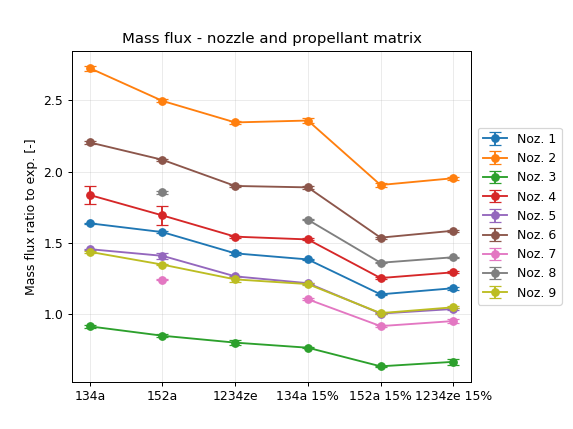

Text(0.5, 1.0, 'Mass flux - nozzle and propellant matrix')

In [216]:
fig=plt.figure()
ax=fig.add_subplot(111)
plt.grid(alpha=.25)


for n in range(len(nn)):
    ax.errorbar(all_props, all_means[:,n], yerr=2.5*all_stds[:,n],\
                capsize=5, marker='o',\
                label='Noz. %i' % nn[n])

plt.ylabel(unit)

# Shrink current axis horizontally
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Mass flux - nozzle and propellant matrix")